In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy import signal
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Загрузим файлы
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.describe()

,ЛПНП
count,553.000000
mean,0.596745
std,0.490995
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [6]:
train.head(5)

,ID,ЛПНП
0,k31__1__1,1
1,k31__5__5,0
2,k31__6__6,0
3,k31__17__17,0
4,k31__16__16,1


In [7]:
train['ЛПНП'].value_counts()

,count
ЛПНП,
1,330
0,223


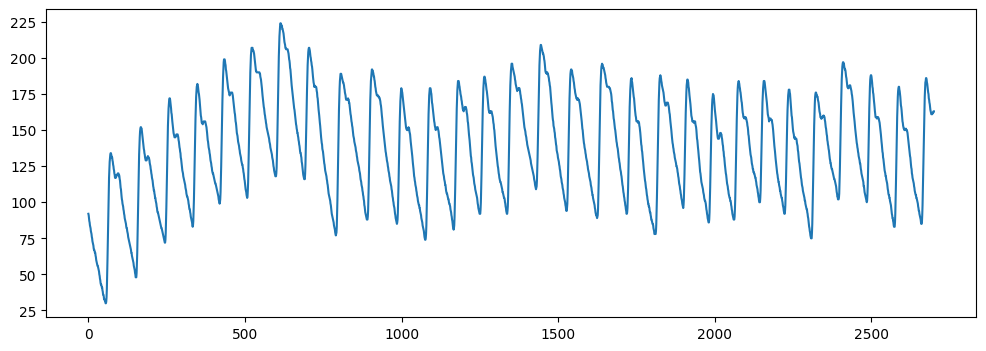

In [8]:
# Загрузим одну из фотоплетизмограмм
file_id = train.iloc[4]['ID']
path = 'ppgs/' + file_id + '.npy'
ppg = np.load(path)
plt.figure(figsize=(12,4))
plt.plot(ppg)

In [9]:
# Разделим обучающую выборку на обучающую и валидационную часть
train, val = train_test_split(train, test_size=0.2, stratify=train['ЛПНП'], random_state=42)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

In [59]:
# Создаем датасет
class PPGDataset(Dataset):
    def __init__(self, df, target_col='ЛПНП', training=True, augment=False):
        self.data = df
        self.target_col = target_col
        self.training = training
        self.augment = augment
        self.fs = 100  # частота дискретизации
        self.crop_size = 700  # минимум 7 секунд

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        file_id = row['ID']
        path = f'ppgs/{file_id}.npy'
        ppg = np.load(path)

        # BANDPASS (можно раскомментировать при желании)
        b, a = signal.butter(3, [0.8 / self.fs, 5 / self.fs], 'bandpass')
        ppg = signal.filtfilt(b, a, ppg)

        # Обрезаем до кратного 128
        ppg = ppg[:128*20]

        ppg = (ppg - ppg.min()) / (ppg.max() - ppg.min() + 1e-8)

        # === АУГМЕНТАЦИИ ===
        if self.training and self.augment:
            ppg = self.signal_augment(ppg)
            ppg = self.spectral_augment(ppg)

        # Конвертация
        ppg = torch.tensor(ppg, dtype=torch.float32).unsqueeze(0)

        if self.training:
            target = torch.tensor(row[self.target_col], dtype=torch.float32)
            return {'ppg': ppg, 'target': target}
        return {'ppg': ppg, 'file_id': file_id}

    def signal_augment(self, x):
        aug_p = 0.2
        # Additive noise (вероятность 0.5)
        if np.random.rand() > 0.5:
            noise = np.random.normal(0, 0.05, size=x.shape)
            x = np.clip(x + noise, 0, 1)

        # Scaling
        if np.random.rand() < 0.4:
            scale = np.random.uniform(0.8, 1.2)
            x = x * scale

        # Time Shift (±0.5 секунды)
        if np.random.rand() < 0.5:
            shift = np.random.randint(-self.fs, self.fs)
            x = np.roll(x, shift)

        # Cropping: случайный фрагмент ≥7 сек (700 точек)
        if len(x) > self.crop_size and np.random.rand() < 0:
            start = np.random.randint(0, len(x) - self.crop_size)
            x = x[start:start + self.crop_size]
            # Zero pad to 128*20 = 2560
            if len(x) < 128*20:
                x = np.pad(x, (0, 128*20 - len(x)))
        return x

    def spectral_augment(self, x):
        aug_p = 0.2
        X = np.fft.rfft(x)
        freqs = np.fft.rfftfreq(len(x), d=1/self.fs)

        # Frequency Masking
        if np.random.rand() < 0.1:
            f_low = np.random.uniform(0.05, 0.2)
            f_high = f_low + np.random.uniform(0.5, 2.0)
            mask = (freqs > f_low) & (freqs < f_high)
            X[mask] = 0

        # Spectral Noise Injection
        if np.random.rand() < 0.1:
            noise = np.random.normal(0, 0.05, size=X.shape) + 1j * np.random.normal(0, 0.05, size=X.shape)
            X += noise

        # Frequency Shifting
        if np.random.rand() < 0.05:
            shift_bins = np.random.randint(-3, 3)
            X = np.roll(X, shift_bins)
            if shift_bins > 0:
                X[:shift_bins] = 0
            elif shift_bins < 0:
                X[shift_bins:] = 0

        x_aug = np.fft.irfft(X)
        x_aug = np.real(x_aug)

        if len(x_aug) < 128*20:
            x_aug = np.pad(x_aug, (0, 128*20 - len(x_aug)))
        return x_aug

In [60]:
# Используемая нейронная сеть (аналог LeNet)
class PPG_CNN_1D(nn.Module):
    def __init__(self, number_of_classes=1, init_method='he'):
        super(PPG_CNN_1D, self).__init__()

        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)

        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(512)

        self.gap = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)

        self._initialize_weights(init_method)

    def _initialize_weights(self, method):
        init_funcs = {
            'xavier': nn.init.xavier_normal_,
            'he': lambda w: nn.init.kaiming_normal_(w, nonlinearity='tanh'),
            'default': lambda w: None
        }
        init_func = init_funcs.get(method, init_funcs['default'])
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                if method != 'default':
                    init_func(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


    def forward(self, x):
      if x.dim() == 2:
        x = x.unsqueeze(1)

      x = self.pool(F.relu(self.bn1(self.conv1(x))))
      x = F.relu(self.bn2(self.conv2(x)))
      x = F.relu(self.bn3(self.conv3(x)))
      x = F.relu(self.bn4(self.conv4(x)))

      x = self.gap(x)
      x = x.view(x.size(0), -1)

      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = self.fc2(x)

      return x.squeeze(1)

In [61]:
# Вспомогательная функция оценки
def evaluate(model, loss_function, val_loader, device):
    model.eval()
    val_loss = 0.0
    val_true = []
    val_pred = []

    with torch.no_grad():
        for data in val_loader:
            inputs = data['ppg']
            if 'target' in data:
                target = data['target']
            else:
                target = None

            inputs = inputs.to(device)
            if target is not None:
                target = target.to(device).float()

            outputs = model(inputs)

            if target is not None:
                target_flat = target.view(-1)
                outputs_flat = outputs.view(-1)

                loss = loss_function(outputs_flat, target_flat)
                val_loss += loss.item() * target.size(0)

                val_true.append(target_flat.cpu())
                val_pred.append(torch.sigmoid(outputs_flat.cpu()))

    if len(val_true) > 0:
        val_true = torch.cat(val_true)
        val_pred = torch.cat(val_pred)
    else:
        val_true = torch.tensor([])
        val_pred = torch.tensor([])

    return val_true, val_pred, (val_loss / len(val_loader.dataset) if len(val_loader) > 0 else 0)

In [62]:
# Функция для обучения модели
def train_ppg_model(model, train_loader, val_loader, loss_function,
                    optimizer, epochs, scheduler=None, metric=None, device='cuda'):

    train_losses, val_losses, val_aucs = [], [], []

    model.to(device)

    best_auc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss_epoch = 0.0
        train_metric_value = 0.0

        for data in train_loader:
            ppg = data['ppg'].to(device)
            target = data['target'].to(device).float()

            optimizer.zero_grad()
            outputs = model(ppg)

            loss_value = loss_function(outputs.view(-1), target.view(-1))
            loss_value.backward()
            optimizer.step()

            train_loss_epoch += loss_value.item() * ppg.size(0)

        train_loss_epoch /= len(train_loader.dataset)

        val_true, val_pred, val_loss_epoch = evaluate(
            model, loss_function, val_loader, device
        )

        try:
            val_auc_score = roc_auc_score(val_true.numpy(), val_pred.numpy())
        except ValueError:
            val_auc_score = 0.5

        if val_auc_score > best_auc:
            best_auc = val_auc_score
            best_model_state = model.state_dict()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_epoch:.4f}, Val Loss: {val_loss_epoch:.4f}, Val AUC: {val_auc_score:.4f}")

        if scheduler is not None:
            scheduler.step(val_auc_score)
            current_lr = scheduler.get_last_lr()[0]
            print(f"Learning rate after epoch {epoch+1}: {current_lr}")

        train_losses.append(train_loss_epoch)
        val_losses.append(val_loss_epoch)
        val_aucs.append(val_auc_score)

    return train_losses, val_losses, val_aucs, best_model_state

In [63]:
# Вычислим веса классов
pos_weight_value = np.sum(train['ЛПНП'] == 0) / np.sum(train['ЛПНП'] == 1)

In [64]:
# Объявление параметров и обучение
BATCH = 10
EPOCHS = 100
LR = 2 * 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
metric = roc_auc_score

train_dataset = PPGDataset(train, augment=True, training=True)
val_dataset = PPGDataset(val, augment=False, training=True)
test_dataset = PPGDataset(test, augment=False, training=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

model = PPG_CNN_1D(init_method='he', number_of_classes=1)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_value], dtype=torch.float32).to(device))
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.8,
    patience=5,
    min_lr = 1e-5
)


history = train_ppg_model(model=model,
                          train_loader=train_loader,
                          val_loader=val_loader,
                          loss_function=loss_function,
                          optimizer=optimizer,
                          epochs=EPOCHS,
                          scheduler=scheduler,
                          device=device)

best_model_state = history[-1]

Epoch 1/100, Train Loss: 0.6248, Val Loss: 0.5631, Val AUC: 0.5532
Learning rate after epoch 1: 0.0002
Epoch 2/100, Train Loss: 0.6208, Val Loss: 0.5798, Val AUC: 0.4327
Learning rate after epoch 2: 0.0002
Epoch 3/100, Train Loss: 0.6038, Val Loss: 0.5508, Val AUC: 0.6401
Learning rate after epoch 3: 0.0002
Epoch 4/100, Train Loss: 0.5748, Val Loss: 0.5287, Val AUC: 0.6539
Learning rate after epoch 4: 0.0002
Epoch 5/100, Train Loss: 0.6129, Val Loss: 0.5456, Val AUC: 0.6300
Learning rate after epoch 5: 0.0002
Epoch 6/100, Train Loss: 0.5962, Val Loss: 0.5701, Val AUC: 0.4239
Learning rate after epoch 6: 0.0002
Epoch 7/100, Train Loss: 0.5704, Val Loss: 0.5439, Val AUC: 0.6444
Learning rate after epoch 7: 0.0002
Epoch 8/100, Train Loss: 0.5772, Val Loss: 0.5466, Val AUC: 0.6448
Learning rate after epoch 8: 0.0002
Epoch 9/100, Train Loss: 0.5698, Val Loss: 0.5355, Val AUC: 0.6529
Learning rate after epoch 9: 0.0002
Epoch 10/100, Train Loss: 0.5523, Val Loss: 0.5443, Val AUC: 0.6448
Learn

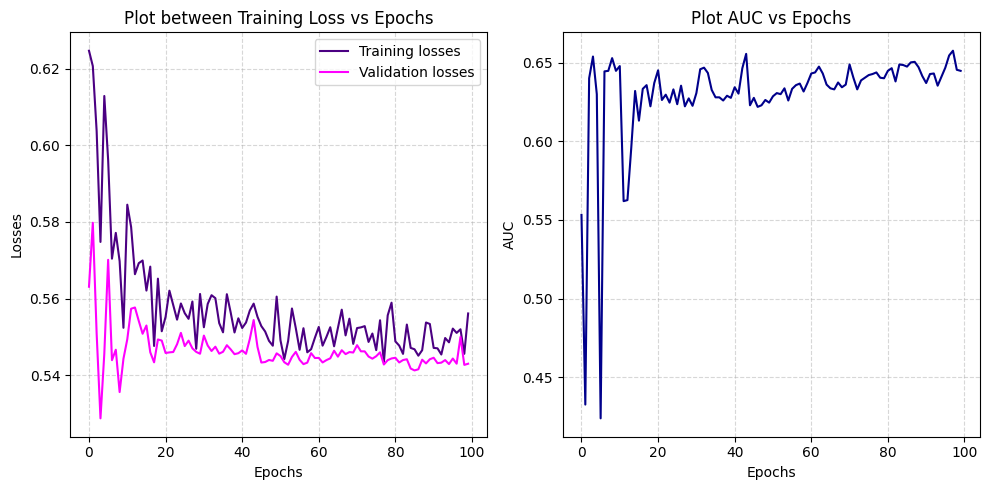

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history[0], color='indigo', label='Training losses')
ax1.plot(history[1], color='magenta', label='Validation losses')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Losses')
ax1.set_title('Plot between Training Loss vs Epochs')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)

ax2.plot(history[2], color='darkblue')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('AUC')
ax2.set_title('Plot AUC vs Epochs')
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [66]:
for name, param in model.named_parameters():
    if param.grad is None:
        print(f"{name} has no grad")
    else:
        print(f"{name} grad norm: {param.grad.norm()}")

conv1.weight grad norm: 0.02428324706852436
conv1.bias grad norm: 1.566242602279999e-08
bn1.weight grad norm: 0.013787377625703812
bn1.bias grad norm: 0.011968802660703659
conv2.weight grad norm: 0.10985004156827927
conv2.bias grad norm: 9.305282100413592e-10
bn2.weight grad norm: 0.009205538779497147
bn2.bias grad norm: 0.007834912277758121
conv3.weight grad norm: 0.11483844369649887
conv3.bias grad norm: 6.754440895484493e-10
bn3.weight grad norm: 0.008490880951285362
bn3.bias grad norm: 0.006547414697706699
conv4.weight grad norm: 0.1389380842447281
conv4.bias grad norm: 3.1464584271390095e-09
bn4.weight grad norm: 0.03830825909972191
bn4.bias grad norm: 0.04697253555059433
fc1.weight grad norm: 0.5121244788169861
fc1.bias grad norm: 0.05764315649867058
fc2.weight grad norm: 1.0927611589431763
fc2.bias grad norm: 0.3394022583961487


In [67]:
model.load_state_dict(best_model_state)
model.eval()
test_preds = []
test_ids = []

with torch.no_grad():
    for data in test_loader:
        ppg = data['ppg'].to(device)
        file_id = data['file_id']
        outputs = model(ppg).view(-1)
        probs = torch.sigmoid(outputs).cpu().numpy()
        test_preds.extend(probs)
        test_ids.extend(file_id)

result_df = pd.DataFrame({
    'ID': test_ids,
    'ЛПНП': test_preds
})
test_predictions = test.merge(result_df, on='ID', how='left')

In [68]:
# Убедимся, что датафрейм с предсказаниями, имеет нужный формат
test_predictions.head()

,ID,ЛПНП
0,k31__2__2,0.608013
1,k31__0__0,0.635919
2,k31__13__13,0.487000
3,k31__14__14,0.529115
4,k31__25__25,0.551554


In [57]:
df = pd.read_csv('submit_2.csv') #для сравнения
df

,ID,ЛПНП
0,k31__2__2,0.663846
1,k31__0__0,0.673297
2,k31__13__13,0.482798
3,k31__14__14,0.551288
4,k31__25__25,0.587831
...,...,...
137,k31__648__648,0.660262
138,k31__635__635,0.394437
139,k31__688__688,0.461302
140,k31__696__696,0.576195


In [69]:
# Сохраним датафрейм с предсказаниями
test_predictions.to_csv('submit_3.csv', index=False)